# <span style="color:blue;">OpenPIV-Python-CPU Tutorial</span>

Please use the following link to run this notebook from Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ali-sh-96/openpiv-python-cpu/blob/main/openpiv_cpu/tutorials/openpiv_python_cpu_tutorial.ipynb)

## <span style="color:blue;">Introduction</span>

This tutorial demonstrates how to use OpenPIV-Python-CPU for particle image velocimetry (PIV) analysis. The data used here consist of a pair of synthetic vortex images (http://www.pivchallenge.org/pub/#b) and low Reynolds number separated flow over an airfoil (acquired in the Turbulence Research Lab, University of Toronto). The synthetic images are 512 by 512 pixels squared, while the separated flow images are 2052 by 4606 pixels squared and approximately 13.9 MB in size. The output from the PIV analyses is displayed as vector plots.

See the References section for a complete description of the iterative multigrid approach in PIV analysis. In brief, at every iteration, the algorithm estimates a velocity field by computing the cross-correlation of square regions around measurement nodes, known as interrogation windows. The estimated field from the cross-correlation is a velocity field for the first iteration, whereas it serves only as a correction for the remaining iterations. This is because the estimated velocity field from the previous iterations is used to shift and deform the windows used in the next iteration, which can result in a more accurate estimation. In between iterations, the estimated velocity field can be processed by smoothing and validation routines. Smaller windows allow for more local estimates of the velocity at the risk of producing spurious vectors.

## <span style="color:blue;">Dependencies</span>

The `openpiv-python-cpu` package only installs the packages strictly needed for PIV analysis, which typically includes `pyfftw`, as `numpy`, `scipy`, and `numba` are already preinstalled in most Python distributions. The choice of other libraries, such as those needed to load or save images, is left to the users. In this tutorial, opencv-python is used to load images.

In [ ]:
#@title Import the needed libraries
#@markdown Run this block to import the dependencies.
import os
import time
import pkg_resources
from glob import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as display

In [ ]:
#@title Install openpiv-python-cpu
#@markdown Run this block to install `openpiv-python-cpu`.
!pip install git+https://github.com/ali-sh-96/openpiv-python-cpu
from openpiv_cpu.cpu_process import piv_cpu

# Get the path to the installed package
openpiv_path = pkg_resources.resource_filename('openpiv_cpu', '')
tutorial_path = os.path.join(openpiv_path, 'tutorials/')

  Cloning https://github.com/ali-sh-96/openpiv-python-cpu to /tmp/pip-req-build-m7dwftzq
  Running command git clone --filter=blob:none --quiet https://github.com/ali-sh-96/openpiv-python-cpu /tmp/pip-req-build-m7dwftzq
  Resolved https://github.com/ali-sh-96/openpiv-python-cpu to commit ad49be4b2c57513b9b9818a7f62aa9041311762d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 5.0 MB/s eta 0:00:00
  Created wheel for OpenPIV-Python-CPU: filename=OpenPIV_Python_CPU-1.1.0-py3-none-any.whl size=23766548 sha256=5dce5e889191b760ae4122c855464eb8838741715c3486c2df2d7c39bf912f6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-9l4dh9u3/wheels/6f/31/b7/db282a2e2db8f3ce11a5831a18d2ae8a26b43fadcd7ba7f225
Successfully built OpenPIV-Python-CPU


## <span style="color:blue;">Descrption of the PIV Parameters</span>

This section provides a detailed description of the input parameters for the `piv_cpu` function. In most scenarios, only a handful of these parameters need to be specified by the users, as illustrated in the following sections by two test cases. The PIV parameters can be modified for each pass. However, once set, these parameters remain constant throughout all iterations for the given window size at that pass. Due to the nature of the algorithm, certain PIV parameters are disregarded during the initial iteration, while some are ignored during the final iteration. It's important to note that the shape of the input images and the minimum window size are not considered as optional PIV settings, and users are required to provide this information when calling the processor.

**Geometric settings**

**`frame_shape`**: Shape of the input image pair in pixels. Note that both images must have the same shape.

**`min_search_size`**: Height and width of the square search window in pixels. In this implementation, the interrogation process relies on the search size rather than the window size, allowing for an extended search area PIV analysis for the first iteration without padding the images. Only multiples of 8 and powers of 2 are supported for performance reasons.

**`search_size_iters`**: The length of this tuple represents the number of different window sizes to be used, and each entry specifies the number of iterations performed for a particular window size. For example, if `min_search_size=16` and `search_size_iters=(1, 2, 2,)`, the window sizes for the passes are 64, 32, and 16, with 1, 2, and 2 iterations for each window size.

**`overlap_ratio`**: Ratio of the overlap between the windows (between 0 and 1) for different window sizes. For example, if `overlap_ratio=(0.5, 0.5, 0.75,)` is used, an overlap of 75% is applied for the final pass.

**`shrink_ratio`**: Ratio (between 0 and 1) to shrink the window size for the first frame to use on the first iteration. For instance, if `shrink_ratio=0.5`, the search size will be two times larger than the window size at the first iteration, allowing for an extended search PIV. Note that extended search PIV is only applicable to the first iteration.

**Correlation settings**

**`deforming_order`**: Order of the spline interpolation used for window deformation. The default of 1 is used to perform a linear spline interpolation.

**`normalize`**: Whether to normalize the window intensity by subtracting the mean intensity. It is recommended to always set this parameter to `True`.

**`subpixel_method`**: Method to estimate the subpixel location of the peak at each iteration. The available methods are _"gaussian"_, _"centroid"_, and _"parabolic"_. The default of _"gaussian"_ is used in most scenarios.

**`n_fft`**: Size-factor of the 2D FFT. Adjusting the correlation width is possible by increasing the size factor and zero-padding the FFT, leading to improved accuracy and fewer outliers in each iteration. Note that increasing the FFT width significantly increases the computation time. It is advised to set `n_fft=2` or at least set the number of FFT points to 2 for the final pass, such as `n_fft=(1, 1, 2,)` for a three-pass PIV.

**`deforming_par`**: Ratio (between 0 and 1) of the previous velocity used to deform each frame at every iteration. A default value of 0.5 is recommended to minimize the bias errors. A value of 1 corresponds to only second frame deformation.

**`batch_size`**: The batch size specifies the number of windows passed for cross-correlation at every iteration. Note that the CPU performs ideally when `batch_size=1`, that is to perform the cross-correlation entirely in serial mode. The batch size parameter is extremely important for the GPU version and is implemented for the CPU for the sake of consistency between the CPU and GPU releases.

**Validation settings**

**`s2n_method`**: Method of the signal-to-noise ratio measurement. The available methods are _"peak2peak"_, _"peak2mean"_, and _"peak2energy"_. The default of _"peak2peak"_ is used if the signal-to-noise ratio validation is required.

**`normalize`**: Whether to normalize the window intensity by subtracting the mean intensity. It is recommended to always set this parameter to `True`.

**`s2n_size`**: Half size of the square region around the first correlation peak to ignore for finding the second peak needed to calculate the signal-to-noise ratio if `s2n_method=`_`"peak2peak"`_.

**`validation_size`**: Size parameter for the validation kernel, `kernel_size=2*size + 1`.

**`s2n_tol`**: Tolerance for the signal-to-noise (S2N) validation at every iteration. For instance, `s2n_tol=(None, None, 2,)` implies that signal-to-noise validation is performed for the final pass only with a tolerance of 2.

**`median_tol`**: Tolerance for the median velocity validation at every iteration.

**`mad_tol`**: Tolerance for the median-absolute-deviation (MAD) velocity validation at every iteration.

**`mean_tol`**: Tolerance for the mean velocity validation at every iteration.

**`rms_tol`**: Tolerance for the root-mean-square (RMS) validation at every iteration. Note that validation methods may be combined by setting different tolerance values for the methods. For example by setting `s2n_tol=None`, `median_tol=2`, `mad_tol=None`, `mean_tol=None`, and `rms_tol=2`, only median and RMS validations are performed with a tolerance of 2 for all passes.

**Replacement settings**

**`num_replacing_iters`**: Number of iterations per replacement cycle. The spring replacement method replaces the outliers altogether, and consequently, this parameter should be set to one for this method. The mean and median methods require more iterations to replace all the spurious vectors successfully.

**`replacing_method`**: Method to use for replacement. The available methods are _"spring"_, _"median"_, and _"mean"_.

**`replacing_size`**: Size parameter for the Replacement kernel, `kernel_size=2*size + 1`.

**`revalidate`**: Whether to revalidate the fields after every replecement iteration. Setting `revalidate=True` reduces the number of iterations required for the convergence of the mean and median replacement methods.

**Smoothing settings**

**`smooth`**: Whether to smooth the fields. Note that no smoothing is done for the last PIV iteration.

**`smoothing_par`**: Smoothing parameter to pass to smoothn to apply to the velocity fields. If `smoothing_par=None`, it is automatically determined using the generalized cross-validation (GCV) method.

**Scaling settings**

**`dt`**: Time delay separating the two frames.

**`scaling_par`**: Scaling factor to apply to the velocity fields. This parameter is typically set to the inverse of the pixel density obtained at the time of the camera calibration to scale the output field.

**Masking settings**

**`mask`**: 2D array of the same shape as the image pair with non-zero values indicating the masked locations. When applying a mask, all values inside the mask are set to `np.nan`. while using `np.nan` is compatible with Python and many scientific libraries, it may cause problems if the results are exported for use in other software that does not handle `np.nan` in the same way. To avoid such problems when exporting data for use in other software, you may replace `np.nan` with an appropriate value such as 0.

**Data type settings**

**`dtype_f`**: Type of the float data. The images are internally converted to float data types before PIV analysis. The available types are _"float32"_ and _"float64"_. The default of single precision is used if not specified.

## <span style="color:blue;">Separated Flow Test Case</span>

This section demonstrates the usage of the module for a pair of actual PIV images obtained for studying low Reynolds number separated flow over an airfoil. An airfoil mask is used to cover the airfoil on the images. The goal is to resolve the velocity field to a window size of 16 pixels.

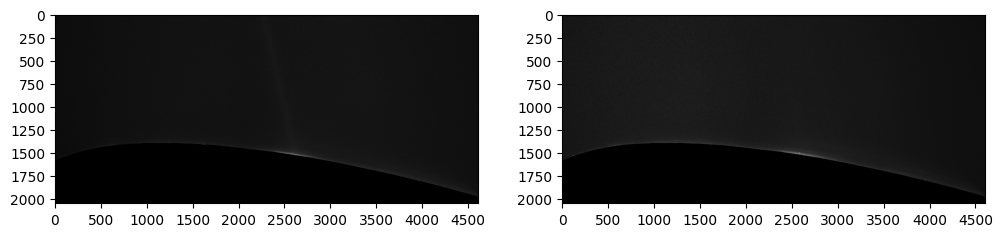

In [ ]:
#@title Load the images
# Load the images.
test_dir = tutorial_path + "test2/"
tif_files = glob(os.path.join(test_dir + '*.tif'))

# Show the images.
frame_a = cv2.imread(tif_files[0], cv2.IMREAD_ANYDEPTH)
frame_b = cv2.imread(tif_files[1], cv2.IMREAD_ANYDEPTH)

fig, axs = plt.subplots(1, 2, figsize=(12,10))
axs[0].imshow(frame_a, cmap=plt.cm.gray)
axs[1].imshow(frame_b, cmap=plt.cm.gray)

# Modify tick labels and ticks.
tick_step = 250
ht, wd = frame_a.shape
for ax in axs:
    ax.set_xticks(range(0, wd, 2 * tick_step))
    ax.set_yticks(range(0, ht, tick_step))

plt.show()

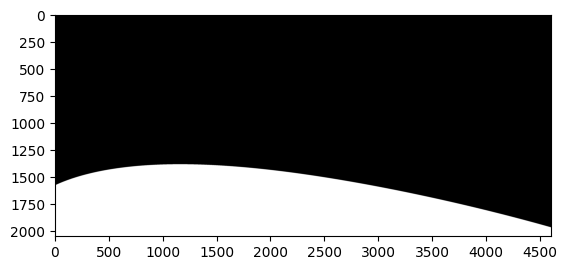

In [ ]:
#@title Load the mask
# Load the airfoil mask.
mask = cv2.imread(test_dir + "airfoil_mask.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap=plt.cm.gray)

# Modify tick labels and ticks.
tick_step = 250
plt.xticks(range(0, wd, 2 * tick_step))
plt.yticks(range(0, ht, tick_step))

plt.show()

In [ ]:
#@title PIV settings
#@markdown The shape of the images is `(2052, 4603)`.
frame_shape = (2052, 4603) #@param {type:"raw"}
min_search_size = 16 #@param [16, 32, 64] {type:"raw"}
search_size_iters = (1, 2, 2,) #@param {type:"raw"}

In [ ]:
#@title Perform PIV processing
#@markdown Run this block to process the images.
# Initialize the process.
process = piv_cpu(frame_shape,
                  min_search_size=16,
                  search_size_iters=(1, 2, 2),
                  mask=mask)

# Get the field coordinates.
x, y = process.coords

# Invert the y axis.
y = y[::-1]

# Process the images.
start_time = time.time()
u, v = process(frame_a, frame_b)
v = -v

# Printout the computation time.
process_time = time.time() - start_time
print('Computation time for {} image pair was {:.3f} s.'.format(1, process_time))

# Get the locations of the unreliable vectors.
loc = process.val_locations
_loc = ~loc

Computation time for 1 image pair was 52.672 s.


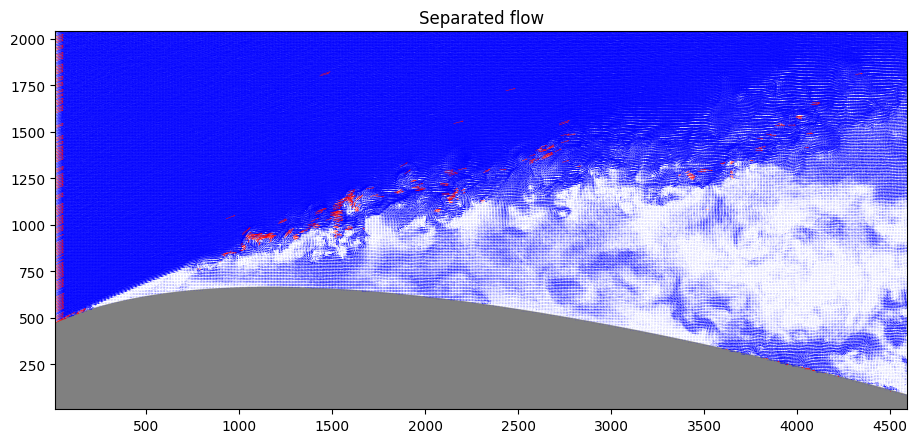

In [ ]:
#@title Plot the results
# Create a figure.
fig, ax = plt.subplots(figsize=(11, 11))
ax.set_aspect(1)
vector_width = 0.0005
vector_scale = 1000

# Modify tick labels and ticks.
tick_step = 250
ax.set_xticks(range(0, int(x[0, -1]), 2 * tick_step))
ax.set_yticks(range(0, int(y[0, -1]), tick_step))

# Adjust the axis limits to the minimum and maximum range.
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())

# Show the quiver plot.
ax.quiver(x[_loc], y[_loc], u[_loc], v[_loc], color="b", width=vector_width, scale=vector_scale)
ax.quiver(x[loc], y[loc], u[loc], v[loc], color="r", width=vector_width, scale=vector_scale)
ax.set_title(f"Separated flow")

# Show the mask on the plot.
ax.imshow(~mask, cmap='gray', alpha=0.5, extent=[x.min(), x.max(), y.min(), y.max()])
plt.show()

## <span style="color:blue;">Vortex Test Case</span>

This section demonstrates the usage of the package for a pair of synthetic images of a strong vortex with variations in seeding concentration and particle image size. The analysis focuses on four distinct cases to illustrate the impact of the validation and replacement methods on the final results using three-passes and a minimum window size of 16 pixels.

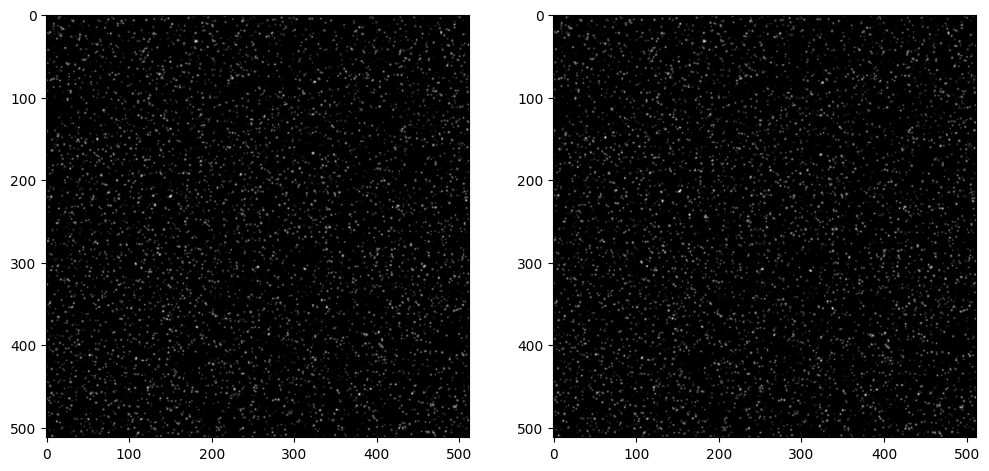

In [ ]:
#@title Load the images
# Load the images.
test_dir = tutorial_path + "test1/"

# Show the images.
frame_a = cv2.imread(test_dir + "B005_1" + ".tif", cv2.IMREAD_ANYDEPTH)
frame_b = cv2.imread(test_dir + "B005_2" + ".tif", cv2.IMREAD_ANYDEPTH)

fig, axs = plt.subplots(1, 2, figsize=(12,10))
axs[0].imshow(frame_a, cmap=plt.cm.gray)
axs[1].imshow(frame_b, cmap=plt.cm.gray)

# Modify tick labels and ticks.
ticks_step = 100
wd, ht = frame_a.shape
for ax in axs:
    ax.set_xticks(range(0, wd, ticks_step))
    ax.set_yticks(range(0, ht, ticks_step))

plt.show()

In [ ]:
#@markdown Run this block to perform 4 analysis, using different validation and replacement settings.
u = []
v = []
loc = []

# Set mandatory settings.
settings = {}
frame_shape = frame_a.shape
min_search_size = 16
settings["search_size_iters"] = (1, 2, 2,)

# Case 1: s2n validation and local mean replacement.
settings["s2n_tol"] = 2
settings["median_tol"] = None
settings["num_replacing_iters"] = 10
settings["replacing_method"] = "mean"
settings["revalidate"] = False
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 1 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Case 2: median validation and local mean replacement.
settings["s2n_tol"] = None
settings["median_tol"] = 2
settings["num_replacing_iters"] = 5
settings["replacing_method"] = "mean"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 2 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Case 3: s2n validation and spring replacement.
settings["s2n_tol"] = 2
settings["median_tol"] = None
settings["num_replacing_iters"] = 1
settings["replacing_method"] = "spring"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 3 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Case 4: median validation and spring replacement.
settings["s2n_tol"] = None
settings["median_tol"] = 2
settings["num_replacing_iters"] = 1
settings["replacing_method"] = "spring"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 4 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Get the coordinates of the field.
x, y = process.coords

# Get the field mask (All False since mask is not provided).
field_mask = process.field_mask

# invert y axis for all.
y = y[::-1]
v = [-vk for vk in v]

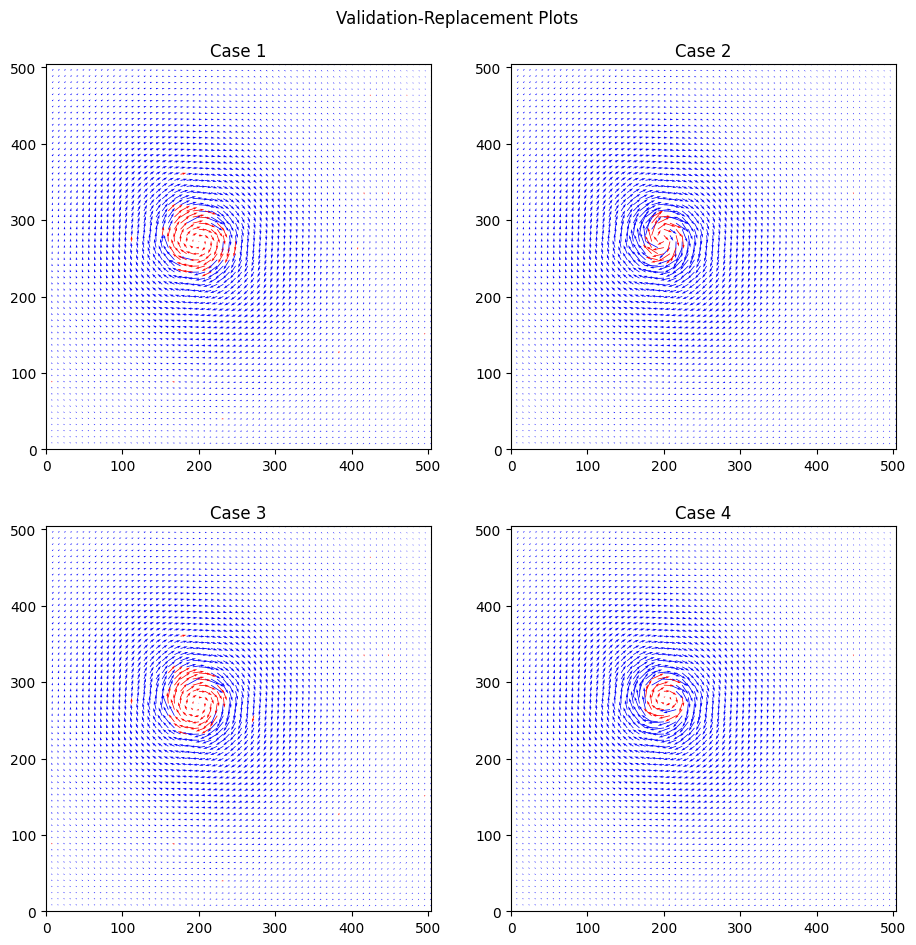

In [ ]:
#@title Plot the results
fig, axs = plt.subplots(2, 2, figsize=(11, 11))
vector_width = 0.002
vector_scale = 250

# Plot the quiver plots.
for i, ax in enumerate(axs.flatten()):
    ax.quiver(x[~loc[i]], y[~loc[i]], u[i][~loc[i]], v[i][~loc[i]], color="blue", width=vector_width, scale=vector_scale)
    ax.quiver(x[loc[i]], y[loc[i]], u[i][loc[i]], v[i][loc[i]], color="red", width=vector_width, scale=vector_scale)

    # Plot settings.
    ax.set_aspect(1)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

# Set titles and labels.
axs[0, 0].set_title('Case 1')
axs[0, 1].set_title('Case 2')
axs[1, 0].set_title('Case 3')
axs[1, 1].set_title('Case 4')

# Modify tick labels and ticks.
ticks_step = 100
for ax in axs.flatten():
    ax.set_xticks(range(0, int(x[0, -1]), ticks_step))
    ax.set_yticks(range(0, int(y[0, -1]), ticks_step))

# Adjust spacing between subplots.
fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.suptitle('Validation-Replacement Plots', y=0.93)
plt.show()

The validation method changes along the columns from `s2n` to `median`, while the replacing method changes along the rows from `mean` to `spring`. Note how the results change at the center of the vortex where signal-to-noise levels are low.

## <span style="color:blue;">References</span>

> Raffel, M., Willert, C. E., & Kompenhans, J. (1998). Particle image velocimetry: a practical guide (Vol. 2, p. 218). Berlin: Springer.

> Scarano, F., & Riethmuller, M. L. (1999). Iterative multigrid approach in PIV image processing with discrete window offset. Experiments in Fluids, 26, 513-523.

> Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high velocity gradients in particle image velocimetry. Experiments in fluids, 35(5), 408-421.
    
> Garcia, D. (2010). Robust smoothing of gridded data in one and higher dimensions with missing values. Computational statistics & data analysis, 54(4), 1167-1178.

> Shirinzad, A., Jaber, K., Xu, K., & Sullivan, P. E. (2023). An Enhanced Python-Based Open-Source Particle Image Velocimetry Software for Use with Central Processing Units. Fluids, 8(11), 285.